# hotel bookings 

#### https://www.kaggle.com/jessemostipak/hotel-booking-demand

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## imports / functions / setup
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
import numpy as np 
import pandas as pd
from datetime import datetime, date
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
#import qgrid
#pd.set_option('display.max_columns',None)

from tqdm import tqdm
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from plotly.offline import init_notebook_mode
from mentoria_ts import plt_ts_categorical, plt_ts_line, plt_ts_boxplot
init_notebook_mode(connected=True)

In [3]:
def add_coluna_faltante(col, df, valor = np.nan, tipo = 'int8'):
    #col_ -> nome da coluna original
    #valor_ -> valor que substitui os valores faltantes
    #df_ -> dataframe a ser alterado
    #tipo_ -> modifica o tipo de dado da coluna
    
    lista = df[col].copy()

    # unir esse where
    lista.where(lista.isnull(), other = 0, inplace = True)
    lista.where(~lista.isnull(), other = 1, inplace = True)

    new = "missing_" + col
    #cria uma feature "missing_name"

    df.insert(df.shape[1],new,lista)
    df[col] = df[col].where(pd.notnull(df[col]), valor)
    df[new]=df[new].astype(tipo)
    
    return df

In [4]:
def acha_mes(mes):
    return list(calendar.month_name).index(mes) 

In [5]:
def plots_agregados():
    
    n = 0
    fig, ax = plt.subplots(1,3, figsize = (24,4))
    for ano in df['arrival_date_w'].unique():
        dataset = df[df['arrival_date_year']==ano].copy()
        #plt.figure(figsize = (12,3))
        graph = sns.countplot(x='arrival_date_month',data = dataset, order = list(calendar.month_name)[1:], ax=ax[n])
        graph.set_xticklabels(graph.get_xticklabels(), rotation = 30)
        graph.set_title(ano)
        #graph.set_xlabel('meses')
        graph.set_ylabel('qtd de bookings')
        n = n + 1

In [6]:
def boxplot_numerical_agg(df, target_col, period_col, category_order = None):

    #target_col, period_col = 'arrival_weekday', 'children'
     
    fig = go.Figure(data = [go.Box(
            x = df.loc[df[period_col] == tp, period_col],
            y = df.loc[df[period_col] == tp, target_col],
            boxmean = True,
            #order = list(calendar.day_name),
            #marker=dict(color=color_palette[i], outliercolor=outlier_color),
            name = str(tp)
        ) for indice, tp in enumerate(aux[period_col].unique())])

    if category_order is not None:
        fig.update_xaxes(categoryorder='array', categoryarray = category_order)

    fig.show()

In [7]:
df = pd.read_csv("hotel_bookings.csv")
df.shape

(119390, 32)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## descrição da base de dados
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Período do arrival date analisado: JULHO/2015 - AGOSTO/2017

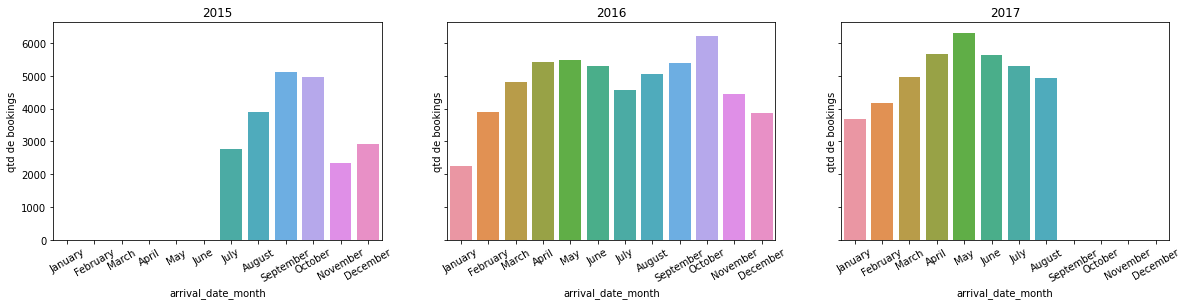

In [8]:
#Acumulado dos meses a cada ano
n = 0
fig, ax = plt.subplots(1,3, figsize = (20,4),sharex = True, sharey = True)
for ano in df['arrival_date_year'].unique():
    dataset = df[df['arrival_date_year']==ano].copy()
    #plt.figure(figsize = (12,3))
    graph = sns.countplot(x='arrival_date_month',data = dataset, order = list(calendar.month_name)[1:], ax=ax[n])
    graph.set_xticklabels(graph.get_xticklabels(), rotation = 30)
    graph.set_title(ano)
    #graph.set_xlabel('meses')
    graph.set_ylabel('qtd de bookings')
    n = n + 1

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## data sanity
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
missing_colunas = [features for features in df.columns if df[features].isnull().sum()>1]
for feature in missing_colunas:
    print(feature, np.round(df[feature].isnull().mean()*100, 4),  ' % de missing values')

children 0.0034  % de missing values
country 0.4087  % de missing values
agent 13.6862  % de missing values
company 94.3069  % de missing values


In [12]:
for feature in ["agent", "company"]:
    df = add_coluna_faltante(col = feature, valor = np.nan, df = df, tipo = 'int8')

In [13]:
print(df[df['agent'].isnull()]['country'].value_counts().sum())
df[df['agent'].isnull()]['country'].value_counts()

16006


PRT    10997
GBR     1240
ESP      720
FRA      605
DEU      289
       ...  
SYR        1
MWI        1
ISL        1
IDN        1
GEO        1
Name: country, Length: 97, dtype: int64

In [14]:
round(df[df['agent'].isnull()]['country'].value_counts()[:10]/df[df['agent'].isnull()]['country'].count() * 100, 2)

PRT    68.71
GBR     7.75
ESP     4.50
FRA     3.78
DEU     1.81
ITA     1.32
BEL     1.16
IRL     1.11
NLD     0.91
BRA     0.86
Name: country, dtype: float64

### Número amplo e predominante de portugueses, com e sem o registro de agente de viagem, o que pode ser indicativo de que os hotéis da análise estão localizadas na proximidades de Portugal

In [15]:
#dropando colunas
df= df.dropna(axis = 0, how ='any', subset = ['children', 'country', 'agent'])
df.reset_index(inplace = True)

In [16]:
numericas = [feature for feature in df.columns if df[feature].dtype in ['float64',"int64"]]
numericas = [feature for feature in numericas if len(df[feature].unique()) != 2]
#binarias = [feature for feature in df.columns if len(df[feature].unique()) == 2]
categoricas = [feature for feature in df.columns if df[feature].dtype=='O']

categoricas.remove("hotel")
categoricas_especiais = ["arrival_date_month","country","reservation_status_date"]
for item in categoricas_especiais: categoricas.remove(item)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## criação de variáveis
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Criando variável 'arrival_date' -> datetime.date  

In [17]:
df['arrival_date_month'] = df['arrival_date_month'].apply(acha_mes)
df["arrival_date"] = df.apply(lambda x: date(x.arrival_date_year, x.arrival_date_month, x.arrival_date_day_of_month), axis=1)

#testando tipo
df["arrival_date"][0]

datetime.date(2015, 7, 1)

### Criando variável 'arrival_weekday' -> dia da semana  

In [18]:
#add arrival_week_day
#print(datetime.today().weekday())
#df['arrival_weekday'].value_counts().sort_index()

print(int(datetime.today().strftime('%w')))
print(datetime.today().strftime('%A'))
df['arrival_weekday'] = df['arrival_date'].apply(lambda x: x.strftime('%A'))

5
Friday


### Criando variável 'enter_date' = 'arrival_date' - 'lead_time' -> data do pedido do booking

In [19]:
#aux['arrival_month'].unique()
df["lead_time"] = pd.to_timedelta(df["lead_time"], unit = "D")
df["arrival_date"] = df.apply(lambda x: datetime(x.arrival_date_year, x.arrival_date_month, x.arrival_date_day_of_month), axis=1)
df["enter_date"] = (df["arrival_date"] - df["lead_time"])
#print(df.enter_date+df.lead_time)

# Tranforma lead_time de days para integer
df["lead_time_int"] = pd.to_numeric(df["lead_time"].dt.days)

In [20]:
df.groupby(['arrival_weekday','arrival_date_month','arrival_date_year']).count().reset_index().head()

arrival_weekday  arrival_date_month  arrival_date_year  index  hotel  \
0          Friday                   1               2016    342    342   
1          Friday                   1               2017    387    387   
2          Friday                   2               2016    627    627   
3          Friday                   2               2017    558    558   
4          Friday                   3               2016    771    771   

   is_canceled  lead_time  arrival_date_week_number  \
0          342        342                       342   
1          387        387                       387   
2          627        627                       627   
3          558        558                       558   
4          771        771                       771   

   arrival_date_day_of_month  stays_in_weekend_nights  ...  adr  \
0                        342                      342  ...  342   
1                        387                      387  ...  387   
2                        627                      627  ...  627   
3                        558                      558  ...  558   
4                        771                      771  ...  771   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                          342                        342                 342   
1                          387                        387                 387   
2                          627                        627                 627   
3                          558                        558                 558   
4                          771                        771                 771   

   reservation_status_date  missing_agent  missing_company  arrival_date  \
0                      342            342              342           342   
1                      387            387              387           387   
2                      627            627              627           627   
3                      558            558              558           558   
4                      771            771              771           771   

   enter_date  lead_time_int  
0         342            342  
1         387            387  
2         627            627  
3         558            558  
4         771            771  

[5 rows x 39 columns]

In [21]:
df.groupby(['arrival_weekday','arrival_date_month','arrival_date_year']).mean().reset_index().head()

arrival_weekday  arrival_date_month  arrival_date_year         index  \
0          Friday                   1               2016  55074.634503   
1          Friday                   1               2017  66566.483204   
2          Friday                   2               2016  39207.730463   
3          Friday                   2               2017  63397.818996   
4          Friday                   3               2016  53097.645914   

   is_canceled  arrival_date_week_number  arrival_date_day_of_month  \
0     0.391813                  3.356725                  17.497076   
1     0.346253                  2.583979                  17.087855   
2     0.425837                  7.637959                  16.465710   
3     0.428315                  6.559140                  13.913978   
4     0.433204                 11.573281                  15.012970   

   stays_in_weekend_nights  stays_in_week_nights    adults  ...  \
0                 0.529240              1.944444  1.853801  ...   
1                 0.751938              2.240310  1.937984  ...   
2                 0.681021              2.255183  1.960128  ...   
3                 0.792115              2.313620  1.951613  ...   
4                 0.836576              2.377432  1.888457  ...   

   booking_changes      agent  company  days_in_waiting_list        adr  \
0         0.163743  76.356725      NaN              5.628655  74.143889   
1         0.206718  94.418605      NaN              0.000000  79.996486   
2         0.122807  90.059011      NaN              0.000000  74.585359   
3         0.170251  94.767025      NaN              0.028674  84.327527   
4         0.210117  90.533074      NaN              7.754864  91.694047   

   required_car_parking_spaces  total_of_special_requests  missing_agent  \
0                     0.076023                   0.508772            0.0   
1                     0.074935                   0.857881            0.0   
2                     0.055821                   0.475279            0.0   
3                     0.051971                   0.711470            0.0   
4                     0.059663                   0.415045            0.0   

   missing_company  lead_time_int  
0              1.0      36.409357  
1              1.0      54.369509  
2              1.0      44.207337  
3              1.0      61.057348  
4              1.0      64.335927  

[5 rows x 25 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## aplicando agregados
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Hipótese: sexta-feira é o dia com mais check-in's da semana

In [22]:
#dataset = df[df['arrival_date_year'] == 2016].copy()

dataset = df.copy()
aux = dataset.groupby(['arrival_weekday','arrival_date_month','arrival_date_year']).count().reset_index()

boxplot_numerical_agg(df = aux, target_col = 'hotel', period_col = 'arrival_weekday', category_order = list(calendar.day_name))

In [23]:
#dataset = df[df['arrival_date_year']==2015].copy()

dataset = df.copy()
aux = dataset.groupby(['arrival_weekday','arrival_date_month','arrival_date_year']).mean().reset_index()

boxplot_numerical_agg(df = aux, target_col = 'lead_time_int', period_col = 'arrival_weekday', category_order = list(calendar.day_name))

In [24]:
operacoes = {"lead_time":"count","children":"mean"}
aux = df.groupby(['arrival_weekday','arrival_date_month','arrival_date_year']).agg(operacoes).reset_index()

In [25]:
aux.head()

arrival_weekday  arrival_date_month  arrival_date_year  lead_time  children
0          Friday                   1               2016        342  0.084795
1          Friday                   1               2017        387  0.129199
2          Friday                   2               2016        627  0.079745
3          Friday                   2               2017        558  0.137993
4          Friday                   3               2016        771  0.098573

In [26]:
dataset.head()

index         hotel  is_canceled lead_time  arrival_date_year  \
0      3  Resort Hotel            0   13 days               2015   
1      4  Resort Hotel            0   14 days               2015   
2      5  Resort Hotel            0   14 days               2015   
3      7  Resort Hotel            0    9 days               2015   
4      8  Resort Hotel            1   85 days               2015   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   7                        27                          1   
1                   7                        27                          1   
2                   7                        27                          1   
3                   7                        27                          1   
4                   7                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  ...  \
0                        0                     1  ...   
1                        0                     2  ...   
2                        0                     2  ...   
3                        0                     2  ...   
4                        0                     3  ...   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          1           Check-Out   
2                            0                          1           Check-Out   
3                            0                          1           Check-Out   
4                            0                          1            Canceled   

  reservation_status_date missing_agent missing_company arrival_date  \
0              2015-07-02             0               1   2015-07-01   
1              2015-07-03             0               1   2015-07-01   
2              2015-07-03             0               1   2015-07-01   
3              2015-07-03             0               1   2015-07-01   
4              2015-05-06             0               1   2015-07-01   

   arrival_weekday  enter_date  lead_time_int  
0        Wednesday  2015-06-18             13  
1        Wednesday  2015-06-17             14  
2        Wednesday  2015-06-17             14  
3        Wednesday  2015-06-22              9  
4        Wednesday  2015-04-07             85  

[5 rows x 39 columns]

In [27]:
#dataset = df[df['arrival_date_year']==2016].copy()

dataset = df
aux = dataset.groupby(['arrival_date_month','arrival_weekday','arrival_date_year']).mean().reset_index()

boxplot_numerical_agg(df = aux, target_col = 'lead_time_int', period_col = 'arrival_date_month')

In [28]:
aux.head()

arrival_date_month arrival_weekday  arrival_date_year         index  \
0                   1          Friday               2016  55074.634503   
1                   1          Friday               2017  66566.483204   
2                   1          Monday               2016  47417.301775   
3                   1          Monday               2017  67603.060721   
4                   1        Saturday               2016  45436.150134   

   is_canceled  arrival_date_week_number  arrival_date_day_of_month  \
0     0.391813                  3.356725                  17.497076   
1     0.346253                  2.583979                  17.087855   
2     0.183432                  3.686391                  15.804734   
3     0.425047                  2.867173                  15.070209   
4     0.286863                  2.337802                  11.364611   

   stays_in_weekend_nights  stays_in_week_nights    adults  ...  \
0                 0.529240              1.944444  1.853801  ...   
1                 0.751938              2.240310  1.937984  ...   
2                 1.112426              1.875740  1.704142  ...   
3                 1.136622              2.324478  1.889943  ...   
4                 1.174263              1.579088  1.882038  ...   

   booking_changes       agent     company  days_in_waiting_list        adr  \
0         0.163743   76.356725         NaN              5.628655  74.143889   
1         0.206718   94.418605         NaN              0.000000  79.996486   
2         0.248521  109.301775         NaN              3.887574  61.704024   
3         0.170778  121.497154  148.500000              0.070209  80.828387   
4         0.158177  108.871314   37.666667              6.099196  74.217802   

   required_car_parking_spaces  total_of_special_requests  missing_agent  \
0                     0.076023                   0.508772            0.0   
1                     0.074935                   0.857881            0.0   
2                     0.047337                   0.443787            0.0   
3                     0.081594                   0.747628            0.0   
4                     0.080429                   0.525469            0.0   

   missing_company  lead_time_int  
0         1.000000      36.409357  
1         1.000000      54.369509  
2         1.000000      22.757396  
3         0.992410      65.087287  
4         0.991957      38.319035  

[5 rows x 25 columns]

In [29]:
#dataset = df[df['arrival_date_year']==2016].copy()

dataset = df.copy()
aux = dataset.groupby(['arrival_date_month', 'arrival_date']).count().reset_index()

In [30]:
col_period, col = 'arrival_date_month', 'children'
aux = df.groupby(['arrival_date_month','arrival_date_year']).count().reset_index()
#aux['arrival_month'] = aux['arrival_date'].apply(lambda x: x.strftime('%m'))

In [31]:
aux.head(3)

arrival_date_month  arrival_date_year  index  hotel  is_canceled  \
0                   1               2016   1775   1775         1775   
1                   1               2017   2771   2771         2771   
2                   2               2016   3047   3047         3047   

   lead_time  arrival_date_week_number  arrival_date_day_of_month  \
0       1775                      1775                       1775   
1       2771                      2771                       2771   
2       3047                      3047                       3047   

   stays_in_weekend_nights  stays_in_week_nights  ...  \
0                     1775                  1775  ...   
1                     2771                  2771  ...   
2                     3047                  3047  ...   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                         1775                       1775                1775   
1                         2771                       2771                2771   
2                         3047                       3047                3047   

   reservation_status_date  missing_agent  missing_company  arrival_date  \
0                     1775           1775             1775          1775   
1                     2771           2771             2771          2771   
2                     3047           3047             3047          3047   

   arrival_weekday  enter_date  lead_time_int  
0             1775        1775           1775  
1             2771        2771           2771  
2             3047        3047           3047  

[3 rows x 39 columns]

In [32]:
plt_ts_categorical(df,"market_segment", time_period = "arrival_date_month")  

c:\Arquivos\Códigos\repositorio\elogroup-projetos\mentoria_timeseries\mentoria_ts.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## proporção e contagem das variáveis categóricas
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
features_categoricas = ['meal','market_segment','customer_type','reservation_status']

for feature in features_categoricas:
    print("\nfeature: {}".format(feature))
    for categoria in df[feature].unique():
        qtd_resort = df[(df['hotel']=='Resort Hotel') & (df[feature]==categoria)][feature].count()
        qtd_cityhotel = df[(df['hotel']=='City Hotel') & (df[feature]==categoria)][feature].count()
        total_hotel = qtd_resort + qtd_cityhotel
        print("{} : \033[1;36;40m resort -> {} ({} %) \033[0m||\033[1;32;40m cityhotel -> {} ({} %) \033[0m ({} %)".format(categoria, qtd_resort, round(qtd_resort/total_hotel*100,2), qtd_cityhotel, round(qtd_cityhotel/total_hotel*100,2),round(total_hotel/df[feature].count()*100,3)))


feature: meal
BB :  resort -> 23078 (29.73 %) || cityhotel -> 54560 (70.27 %)  (75.454 %)
FB :  resort -> 635 (94.63 %) || cityhotel -> 36 (5.37 %)  (0.652 %)
HB :  resort -> 7120 (53.05 %) || cityhotel -> 6301 (46.95 %)  (13.044 %)
SC :  resort -> 50 (0.48 %) || cityhotel -> 10284 (99.52 %)  (10.043 %)
Undefined :  resort -> 830 (100.0 %) || cityhotel -> 0 (0.0 %)  (0.807 %)

feature: market_segment
Corporate :  resort -> 381 (55.06 %) || cityhotel -> 311 (44.94 %)  (0.673 %)
Online TA :  resort -> 17511 (31.24 %) || cityhotel -> 38546 (68.76 %)  (54.48 %)
Direct :  resort -> 2927 (44.47 %) || cityhotel -> 3655 (55.53 %)  (6.397 %)
Offline TA/TO :  resort -> 7255 (30.52 %) || cityhotel -> 16519 (69.48 %)  (23.105 %)
Groups :  resort -> 3589 (22.92 %) || cityhotel -> 12072 (77.08 %)  (15.221 %)
Complementary :  resort -> 50 (48.54 %) || cityhotel -> 53 (51.46 %)  (0.1 %)
Aviation :  resort -> 0 (0.0 %) || cityhotel -> 25 (100.0 %)  (0.024 %)

feature: customer_type
Transient :  resort

### Testando Resampling 

In [34]:
df.head(3)

index         hotel  is_canceled lead_time  arrival_date_year  \
0      3  Resort Hotel            0   13 days               2015   
1      4  Resort Hotel            0   14 days               2015   
2      5  Resort Hotel            0   14 days               2015   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   7                        27                          1   
1                   7                        27                          1   
2                   7                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  ...  \
0                        0                     1  ...   
1                        0                     2  ...   
2                        0                     2  ...   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          1           Check-Out   
2                            0                          1           Check-Out   

  reservation_status_date missing_agent missing_company arrival_date  \
0              2015-07-02             0               1   2015-07-01   
1              2015-07-03             0               1   2015-07-01   
2              2015-07-03             0               1   2015-07-01   

   arrival_weekday  enter_date  lead_time_int  
0        Wednesday  2015-06-18             13  
1        Wednesday  2015-06-17             14  
2        Wednesday  2015-06-17             14  

[3 rows x 39 columns]

In [35]:
#print(categoricas_especiais)
dataset = df.copy()
dataset['arrival_date'] = dataset['arrival_date'].apply(lambda x : datetime.combine(x, datetime.min.time()))
dataset = dataset.set_index('arrival_date')
#df['arrival_date'].apply(datetime)
#df_1.set_index("arrival_date").info()
dataset = dataset.resample("W").count()

In [36]:
fig = px.line(data_frame = dataset['lead_time'],
             title="Quantidade de Bookings ", labels={"value":"quantidade de bookings","arrival_date":"data de chegada"})
fig.show()

In [37]:
print(type(dataset.index))
dataset.index

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


DatetimeIndex(['2015-07-05', '2015-07-12', '2015-07-19', '2015-07-26',
               '2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06',
               ...
               '2017-07-02', '2017-07-09', '2017-07-16', '2017-07-23',
               '2017-07-30', '2017-08-06', '2017-08-13', '2017-08-20',
               '2017-08-27', '2017-09-03'],
              dtype='datetime64[ns]', name='arrival_date', length=114, freq='W-SUN')

In [38]:
plt_ts_categorical(df,"country", time_period = "arrival_date_month")

c:\Arquivos\Códigos\repositorio\elogroup-projetos\mentoria_timeseries\mentoria_ts.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## hipóteses
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Explorando a variável 'country'

In [39]:
df['country'].value_counts()

PRT    37591
GBR    10889
FRA     9810
ESP     7848
DEU     6998
       ...  
FJI        1
NIC        1
HND        1
BFA        1
ASM        1
Name: country, Length: 174, dtype: int64

In [40]:
round(df['country'].value_counts()[:10]/df['country'].count() * 100, 2)

PRT    36.53
GBR    10.58
FRA     9.53
ESP     7.63
DEU     6.80
ITA     3.46
IRL     3.11
BEL     2.10
BRA     2.03
USA     1.91
Name: country, dtype: float64

In [41]:
df_test = df[df['country'] == "PRT"]
df_test['country'].value_counts()

PRT    37591
Name: country, dtype: int64

In [42]:
df_test.head()

index         hotel  is_canceled lead_time  arrival_date_year  \
3      7  Resort Hotel            0    9 days               2015   
4      8  Resort Hotel            1   85 days               2015   
5      9  Resort Hotel            1   75 days               2015   
6     10  Resort Hotel            1   23 days               2015   
7     11  Resort Hotel            0   35 days               2015   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
3                   7                        27                          1   
4                   7                        27                          1   
5                   7                        27                          1   
6                   7                        27                          1   
7                   7                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  ...  \
3                        0                     2  ...   
4                        0                     3  ...   
5                        0                     3  ...   
6                        0                     4  ...   
7                        0                     4  ...   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
3                            0                          1           Check-Out   
4                            0                          1            Canceled   
5                            0                          0            Canceled   
6                            0                          0            Canceled   
7                            0                          0           Check-Out   

  reservation_status_date missing_agent missing_company arrival_date  \
3              2015-07-03             0               1   2015-07-01   
4              2015-05-06             0               1   2015-07-01   
5              2015-04-22             0               1   2015-07-01   
6              2015-06-23             0               1   2015-07-01   
7              2015-07-05             0               1   2015-07-01   

   arrival_weekday  enter_date  lead_time_int  
3        Wednesday  2015-06-22              9  
4        Wednesday  2015-04-07             85  
5        Wednesday  2015-04-17             75  
6        Wednesday  2015-06-08             23  
7        Wednesday  2015-05-27             35  

[5 rows x 39 columns]

### 1) Os portugueses possuem um comportamento diferente do agregado de turistas de outras nacionalidades. 

In [43]:
print("all ->", df['country'].value_counts().sum())
print("PRT ->", df['country'].value_counts()[:1].sum())
print("top 4 depois de PRT ->",df['country'].value_counts()[1:5].sum())
print("agregado do resto ->", df['country'].value_counts()[5:].sum())

#https://www.xotels.com/en/revenue-management/revenue-management-book/hotel-market-segmentation

all -> 102894
PRT -> 37591
top 4 depois de PRT -> 35545
agregado do resto -> 29758


In [44]:
dataset = df_test.copy()
aux = dataset.groupby(['arrival_date']).count().reset_index()
aux['arrival_weekday'] = aux['arrival_date'].apply(lambda x: x.strftime('%A'))
aux = dataset.groupby(['arrival_date_month', 'arrival_date']).count().reset_index()

#boxplot_numerical_agg(df = df_test, target_col = 'hotel', period_col = 'arrival_date_month')

In [45]:
features_categoricas = ['meal','market_segment','customer_type','reservation_status']

for feature in features_categoricas:
    print("\nfeature: {}".format(feature))
    for categoria in df_test[feature].unique():
        qtd_resort = df_test[(df_test['hotel']=='Resort Hotel') & (df_test[feature]==categoria)][feature].count()
        qtd_cityhotel = df_test[(df_test['hotel']=='City Hotel') & (df_test[feature]==categoria)][feature].count()
        total_hotel = qtd_resort + qtd_cityhotel
        print("{} : \033[1;36;40m resort -> {} ({} %) \033[0m||\033[1;32;40m cityhotel -> {} ({} %) \033[0m ({} %)".format(categoria, qtd_resort, round(qtd_resort/total_hotel*100,2), qtd_cityhotel, round(qtd_cityhotel/total_hotel*100,2),round(total_hotel/df_test[feature].count()*100,3)))


feature: meal
FB :  resort -> 443 (92.48 %) || cityhotel -> 36 (7.52 %)  (1.274 %)
BB :  resort -> 8723 (29.26 %) || cityhotel -> 21090 (70.74 %)  (79.309 %)
HB :  resort -> 2703 (49.32 %) || cityhotel -> 2778 (50.68 %)  (14.581 %)
Undefined :  resort -> 399 (100.0 %) || cityhotel -> 0 (0.0 %)  (1.061 %)
SC :  resort -> 17 (1.2 %) || cityhotel -> 1402 (98.8 %)  (3.775 %)

feature: market_segment
Direct :  resort -> 1389 (66.55 %) || cityhotel -> 698 (33.45 %)  (5.552 %)
Online TA :  resort -> 6414 (54.14 %) || cityhotel -> 5434 (45.86 %)  (31.518 %)
Offline TA/TO :  resort -> 2364 (20.21 %) || cityhotel -> 9331 (79.79 %)  (31.111 %)
Corporate :  resort -> 261 (58.13 %) || cityhotel -> 188 (41.87 %)  (1.194 %)
Groups :  resort -> 1836 (16.06 %) || cityhotel -> 9596 (83.94 %)  (30.412 %)
Complementary :  resort -> 21 (30.43 %) || cityhotel -> 48 (69.57 %)  (0.184 %)
Aviation :  resort -> 0 (0.0 %) || cityhotel -> 11 (100.0 %)  (0.029 %)

feature: customer_type
Transient :  resort -> 100

In [46]:
dataset = df.copy()
dataset['arrival_date'] = dataset['arrival_date'].apply(lambda x : datetime.combine(x, datetime.min.time()))
dataset = dataset.set_index('arrival_date')
#df['arrival_date'].apply(datetime)
#df_1.set_index("arrival_date").info()
dataset = dataset.resample("W").count()

In [47]:
fig = px.box(data_frame = df, x="lead_time_int", color= "is_canceled")
fig.show()

In [48]:
dia = "2015-12-05"
dia = datetime.strptime(dia, "%Y-%m-%d").date()
print(type(dia))

<class 'datetime.date'>


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102894 entries, 0 to 102893
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   index                           102894 non-null  int64          
 1   hotel                           102894 non-null  object         
 2   is_canceled                     102894 non-null  int64          
 3   lead_time                       102894 non-null  timedelta64[ns]
 4   arrival_date_year               102894 non-null  int64          
 5   arrival_date_month              102894 non-null  int64          
 6   arrival_date_week_number        102894 non-null  int64          
 7   arrival_date_day_of_month       102894 non-null  int64          
 8   stays_in_weekend_nights         102894 non-null  int64          
 9   stays_in_week_nights            102894 non-null  int64          
 10  adults                          102894 non-n

In [50]:
df.to_pickle("bookings.pkl")

In [51]:
#df.groupby("arrival_date").count()
#df[df["arrival_date"] == dia]
#df["enter_date"][0]
#df['lead_time']
'''
fig = px.line(data_frame = df_test.groupby("arrival_date")["arrival_date_week_number"].count(),
             title="Quantidade de Bookings por Data de Chegada", labels={"value":"quantidade de bookings","arrival_date":"data de chegada"})
fig.show() 
'''

'\nfig = px.line(data_frame = df_test.groupby("arrival_date")["arrival_date_week_number"].count(),\n             title="Quantidade de Bookings por Data de Chegada", labels={"value":"quantidade de bookings","arrival_date":"data de chegada"})\nfig.show() \n'

In [52]:
# add 'lead_time' + 'is_canceled'
# add distrib.
# add 'adr' 
# add 'country'

# boxplot do seaborn

#plt.figure(figsize=(20,4))
#ax = sns.boxplot(data=df , x= "lead_int",  y="hotel", orient="h", palette="Set2")

# violinplot do plotly
#fig = px.violin(df, y="lead_int",color="hotel", box = True, points = "outliers")
#fig.show()

# boxplot do plotly 

'''
plt.figure(figsize = (8,4))
sns.heatmap(df[missing_colunas].isnull(),
           yticklabels=0,
           cbar = False)
plt.title('Visão Geral dos Valores Faltantes')
plt.xlabel('atributos')
plt.show()
'''

"\nplt.figure(figsize = (8,4))\nsns.heatmap(df[missing_colunas].isnull(),\n           yticklabels=0,\n           cbar = False)\nplt.title('Visão Geral dos Valores Faltantes')\nplt.xlabel('atributos')\nplt.show()\n"

In [53]:
'''fig = px.line(data_frame = ,
             title = "Quantidade de Bookings por Dia de Pedido", labels={"value":"quantidade de bookings","arrival_date":"data do pedido"})
fig.show()
'''

'fig = px.line(data_frame = ,\n             title = "Quantidade de Bookings por Dia de Pedido", labels={"value":"quantidade de bookings","arrival_date":"data do pedido"})\nfig.show()\n'